# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Timing code

(borrowed from https://stackoverflow.com/questions/7370801/measure-time-elapsed-in-python)

In [2]:
from contextlib import contextmanager
from timeit import default_timer

@contextmanager
def elapsed_timer():
    start = default_timer()
    elapser = lambda: default_timer() - start
    yield lambda: elapser()
    end = default_timer()
    elapser = lambda: end-start

In [3]:
with elapsed_timer() as my_timer:
    sum = 0
    for x in range(1000000):
        sum += x
    print(my_timer())
    for x in range(1000000):
        sum += x
     
print(my_timer())

0.15074590499989426
0.2894640349998099


# MNIST

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [6]:
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
some_digit = X[0]
X_train.shape

(60000, 784)

# Multiclass classification

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

In [21]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) 

with elapsed_timer() as svm_timer:
    svm_clf.fit(X_train[:1000], y_train[:1000])
print(f"svm_clf.fit took {svm_timer():.3f} secs")

svm_clf.predict([some_digit])

svm_clf.fit took 1.799 secs


array([5], dtype=uint8)

#### Timer: svm_clf.fit took 1.799 secs

In [22]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])

with elapsed_timer() as ovr_timer:
    ovr_clf.fit(X_train[:1000], y_train[:1000])
print(f"ovr_clf.fit took {ovr_timer():.3f} secs")

ovr_clf.predict([some_digit])

ovr_clf.fit took 10.391 secs


array([5], dtype=uint8)

#### Timer: ovr_clf.fit took 10.391 secs

In [11]:
len(ovr_clf.estimators_)

10

In [12]:
with elapsed_timer() as sgd_timer:
    sgd_clf.fit(X_train, y_train)
print(f"sgd_clf.fit took {sgd_timer():.3f} secs")
sgd_clf.predict([some_digit])

sgd_clf.fit took 149.187 secs


array([3], dtype=uint8)

#### Timer: sgd_clf.fit took 149.187 secs

In [13]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [14]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87082583, 0.87089354, 0.88628294])

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/Users/charliepoff-webster/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/Users/charliepoff-webster/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]])

## KNN classifier

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [18]:
y_knn_pred = knn_clf.predict(X_test)

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

## SVC vs OneVsRestClassifiers

Wrap the training for the SVC and OneVsRestClassifiers in timing constructs so you can see how long they take. Then conduct some experiments in which you try successively larger amounts of training data, doubling the size a few times to get a sense of the underlying complexity. You probably want to set up these experiments so they complete without interaction and then run them while you go read your book (or take a long nap :-).

In [ ]:
def versusComplexityTest(sizes):
    svc_times = []
    ovr_times = []
    
    for size in sizes:
        svc_clf = SVC(gamma="auto", random_state=42)
        with elapsed_timer() as svc_timer:
            svc_clf.fit(X_train[:size], y_train[:size])
        svc_times.append((size, svc_timer))
        
        ovr_clf = OneVsRestClassifier(SVC(gamme="auto", random_state=42))
        with elapsed_timer() as ovr_timer:
            ovr_clf.fit(X_train[:size], y_train[:size])
        ovr_times.append((size, ovr_timer))
        
    print(svc_times)
    print(ovr_times)

In [ ]:
versusComplexityTest([1000, 2000, 4000])

## Speeding Things Up, pt. 1

Consider the image on p. 199 of the book (or find the same in the notebook for chapter 7). This suggests that maybe we could train and predict on a smaller image and still do pretty well. Begin by just removing pixels around the edges of the image - how many is up to you. Hint: reshape the image from (784,) to (28, 28) and then use Numpy slicing (that's the : operator) to do this, then reshape back to one dimension. Remember to do the same thing when you predict!

Now try the same thing, but this time actually use the importance values generated in the book, pick a few thresholds and subsample the images using only the most important pixels. You'll want to look at how to use what Numpy calls "masking" here.

In [308]:
X_train_reshape = np.zeros((60000, 484)) # 22*22 = 484
X_test_reshape = np.zeros((10000, 484))

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image[4:26,4:26], cmap = mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

def crop_data(data, row_index, train_vs_test):
    image = data.reshape(28, 28)
    if train_vs_test:
        X_train_reshape[row_index] = np.reshape(image[4:26, 4:26], (484,))
    else:
        X_test_reshape[row_index] = np.reshape(image[4:26, 4:26], (484,))

In [309]:
for number in range(0, 10):
    plot_digit(X_train[number])
    cbar = plt.colorbar(ticks=[X_train[number].min(), X_train[number].max()])
    cbar.ax.set_yticklabels(['Not important', 'Very important'])
    plt.show()

for number in range(0, 60000):
    crop_data(X_train[number], number, True)
    
for number in range(0, 10000):
    crop_data(X_test[number], number, False)

In [310]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train_reshape, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [311]:
y_knn_pred = knn_clf.predict(X_test_reshape)

In [312]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9712

This isn't surprising that the accuracy score is basically the same as the earlier accuracy score. What is more important is how long it takes.

Now to compare we will use a random forest classifier so that we can minimize the data using feature_importances_

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(X_train, y_train)

In [250]:
import numpy.ma as ma

X_train_reshape_forest_threshold = []

def plot_digit_combined_mask(data, threshold):
    mask_array = []
    for i in data:
        if i < threshold:
            mask_array.append(1)
        else:
            mask_array.append(0)
            if (threshold == .001):
                X_train_reshape_forest_threshold.append(i)
            
    image_mask = ma.masked_array(data.reshape(28, 28), mask_array)
    plt.imshow(image_mask, cmap = mpl.cm.hot, interpolation="nearest")  
    plt.title("Threshold: " + str(threshold))
    plt.axis("off")

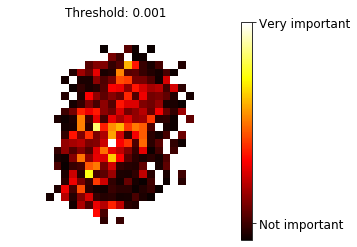

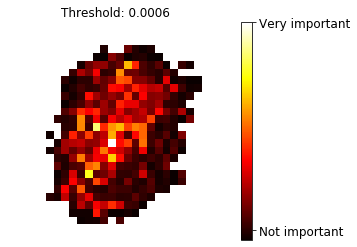

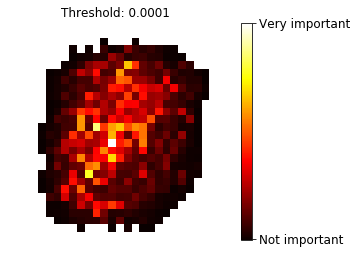

In [251]:
thresholds = [.001, .0006, .0001]

for threshold in thresholds:
    plot_digit_combined_mask(rnd_clf.feature_importances_, threshold)
    cbar = plt.colorbar(ticks=[threshold*2, rnd_clf.feature_importances_.max()])
    cbar.ax.set_yticklabels(['Not important', 'Very important'])
    plt.show()

Now use masking on each of the 60000 images:

In [379]:
# X_train_reshape_mask = []
# X_test_reshape_mask = []

# def plot_digit_threshold_mask(data):
#     mask_array = []
#     for i in data:
#         if i < .001:
#             mask_array.append(1)
#         else:
#             mask_array.append(0)
#             if (threshold == .001):
#                 X_train_reshape_mask.append(i)

#     image_mask = ma.masked_array(data.reshape(28, 28), mask_array)
#     plt.imshow(image_mask, cmap = mpl.cm.hot, interpolation="nearest")  
#     plt.axis("off")

# def crop_data_threshold_mask(data, row_index, train_vs_test):
    
#     mask_array_train = []
#     mask_array_test = []
#     for i in data:
#         if i < .001:
#             # mask_array.append(1)
#             x = 1
#         else:
#             # mask_array.append(0)
#             if (threshold < .001):
#                 if train_vs_test:
#     #                     X_train_reshape_mask.append(i)
#                     mask_array_train.append(i)
#                 else:
#                     # X_test_reshape_mask.append(i)
#                     mask_array_test.append(i)

#     if train_vs_test:
#         X_train_reshape_mask[row_index] = np.reshape(mask_array_train, (len(mask_array_train),))
#     else:
#         X_test_reshape_mask[row_index] = np.reshape(mask_array_test, (len(mask_array_test),))
        
# # #     image_mask = ma.masked_array(data.reshape(28, 28), mask_array)
# #     if train_vs_test:
# #         for data in mask_array:
# # #             X_train_reshape_mask[row_index][np.reshape(np.asmatrix(X_train_reshape_mask), (X_train_reshape_mask.size, 1))]
# #             X_train_reshape_mask[row_index][data]
# #     else:
# # #         X_test_reshape_mask[row_index][np.reshape(X_train_reshape_mask, (X_train_reshape_mask.size, 1))]
# #         for data in mask_array:
# #             X_test_reshape_mask[row_index][data]

X_train_reshape_mask = np.zeros((60000, 484))
X_test_reshape_mask = np.zeros((10000, 484))

def plot_digit_threshold_mask(data):
    mask_array = []
    for i in data:
        if i < .001:
            mask_array.append(1)
        else:
            mask_array.append(0)
            X_train_reshape_mask.append(i)

    image_mask = ma.masked_array(data.reshape(28, 28), mask_array)
    plt.imshow(image_mask, cmap = mpl.cm.hot, interpolation="nearest")  
    plt.axis("off")

def crop_data_threshold_mask(data, row_index, train_vs_test):
    mask_array_train = []
    mask_array_test = []
    for i in data:
        if i > .001:
            if train_vs_test:
                mask_array_train.append(i)
            else:
                mask_array_test.append(i)

    if train_vs_test:
        for i in range(0, len(mask_array_train)):
            X_train_reshape_mask[row_index][i] = mask_array_train[i]
#         X_train_reshape_mask[row_index] = np.reshape(mask_array_train, (len(mask_array_train),))
    else:
        for i in range(0, len(mask_array_test)):
            X_test_reshape_mask[row_index][i] = mask_array_test[i]
#         X_test_reshape_mask[row_index] = np.reshape(mask_array_test, (len(mask_array_test),))

In [380]:
for number in range(0, 10):
    plot_digit_threshold_mask(X_train[number])
    cbar = plt.colorbar(ticks=[.001, X_train[number].max()])
    cbar.ax.set_yticklabels(['Not important', 'Very important'])
    plt.show()

for number in range(0, 60000):
    crop_data_threshold_mask(X_train[number], number, True)
    
for number in range(0, 10000):
    crop_data_threshold_mask(X_test[number], number, False)

In [381]:
print(X_train_reshape_mask)

[[  3.  18.  18. ...   0.   0.   0.]
 [ 51. 159. 253. ...   0.   0.   0.]
 [ 67. 232.  39. ...   0.   0.   0.]
 ...
 [ 96. 121. 213. ...   0.   0.   0.]
 [ 55. 192. 230. ...   0.   0.   0.]
 [ 38.  48.  48. ...   0.   0.   0.]]


In [382]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train_reshape_mask, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [383]:
y_knn_pred = knn_clf.predict(X_test_reshape_mask)

In [384]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.5884

## Speeding Things Up, pt. 2

Use PCA to reduce the dimensionality of the space. Directly compare this approach with your results in part 1 by choosing a reduced input space of the same size you experimented with there. Then also try the reduction that preserves just more than 80% of the variance and see how that performs in terms of accuracy.